# Introduction

Objective:
    
Background:

Data: 
https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_products_dataset.csv

Inspiration: 
* https://medium.com/datadriveninvestor/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6
* https://www.kaggle.com/robottums/hybrid-recommender-systems-with-surprise

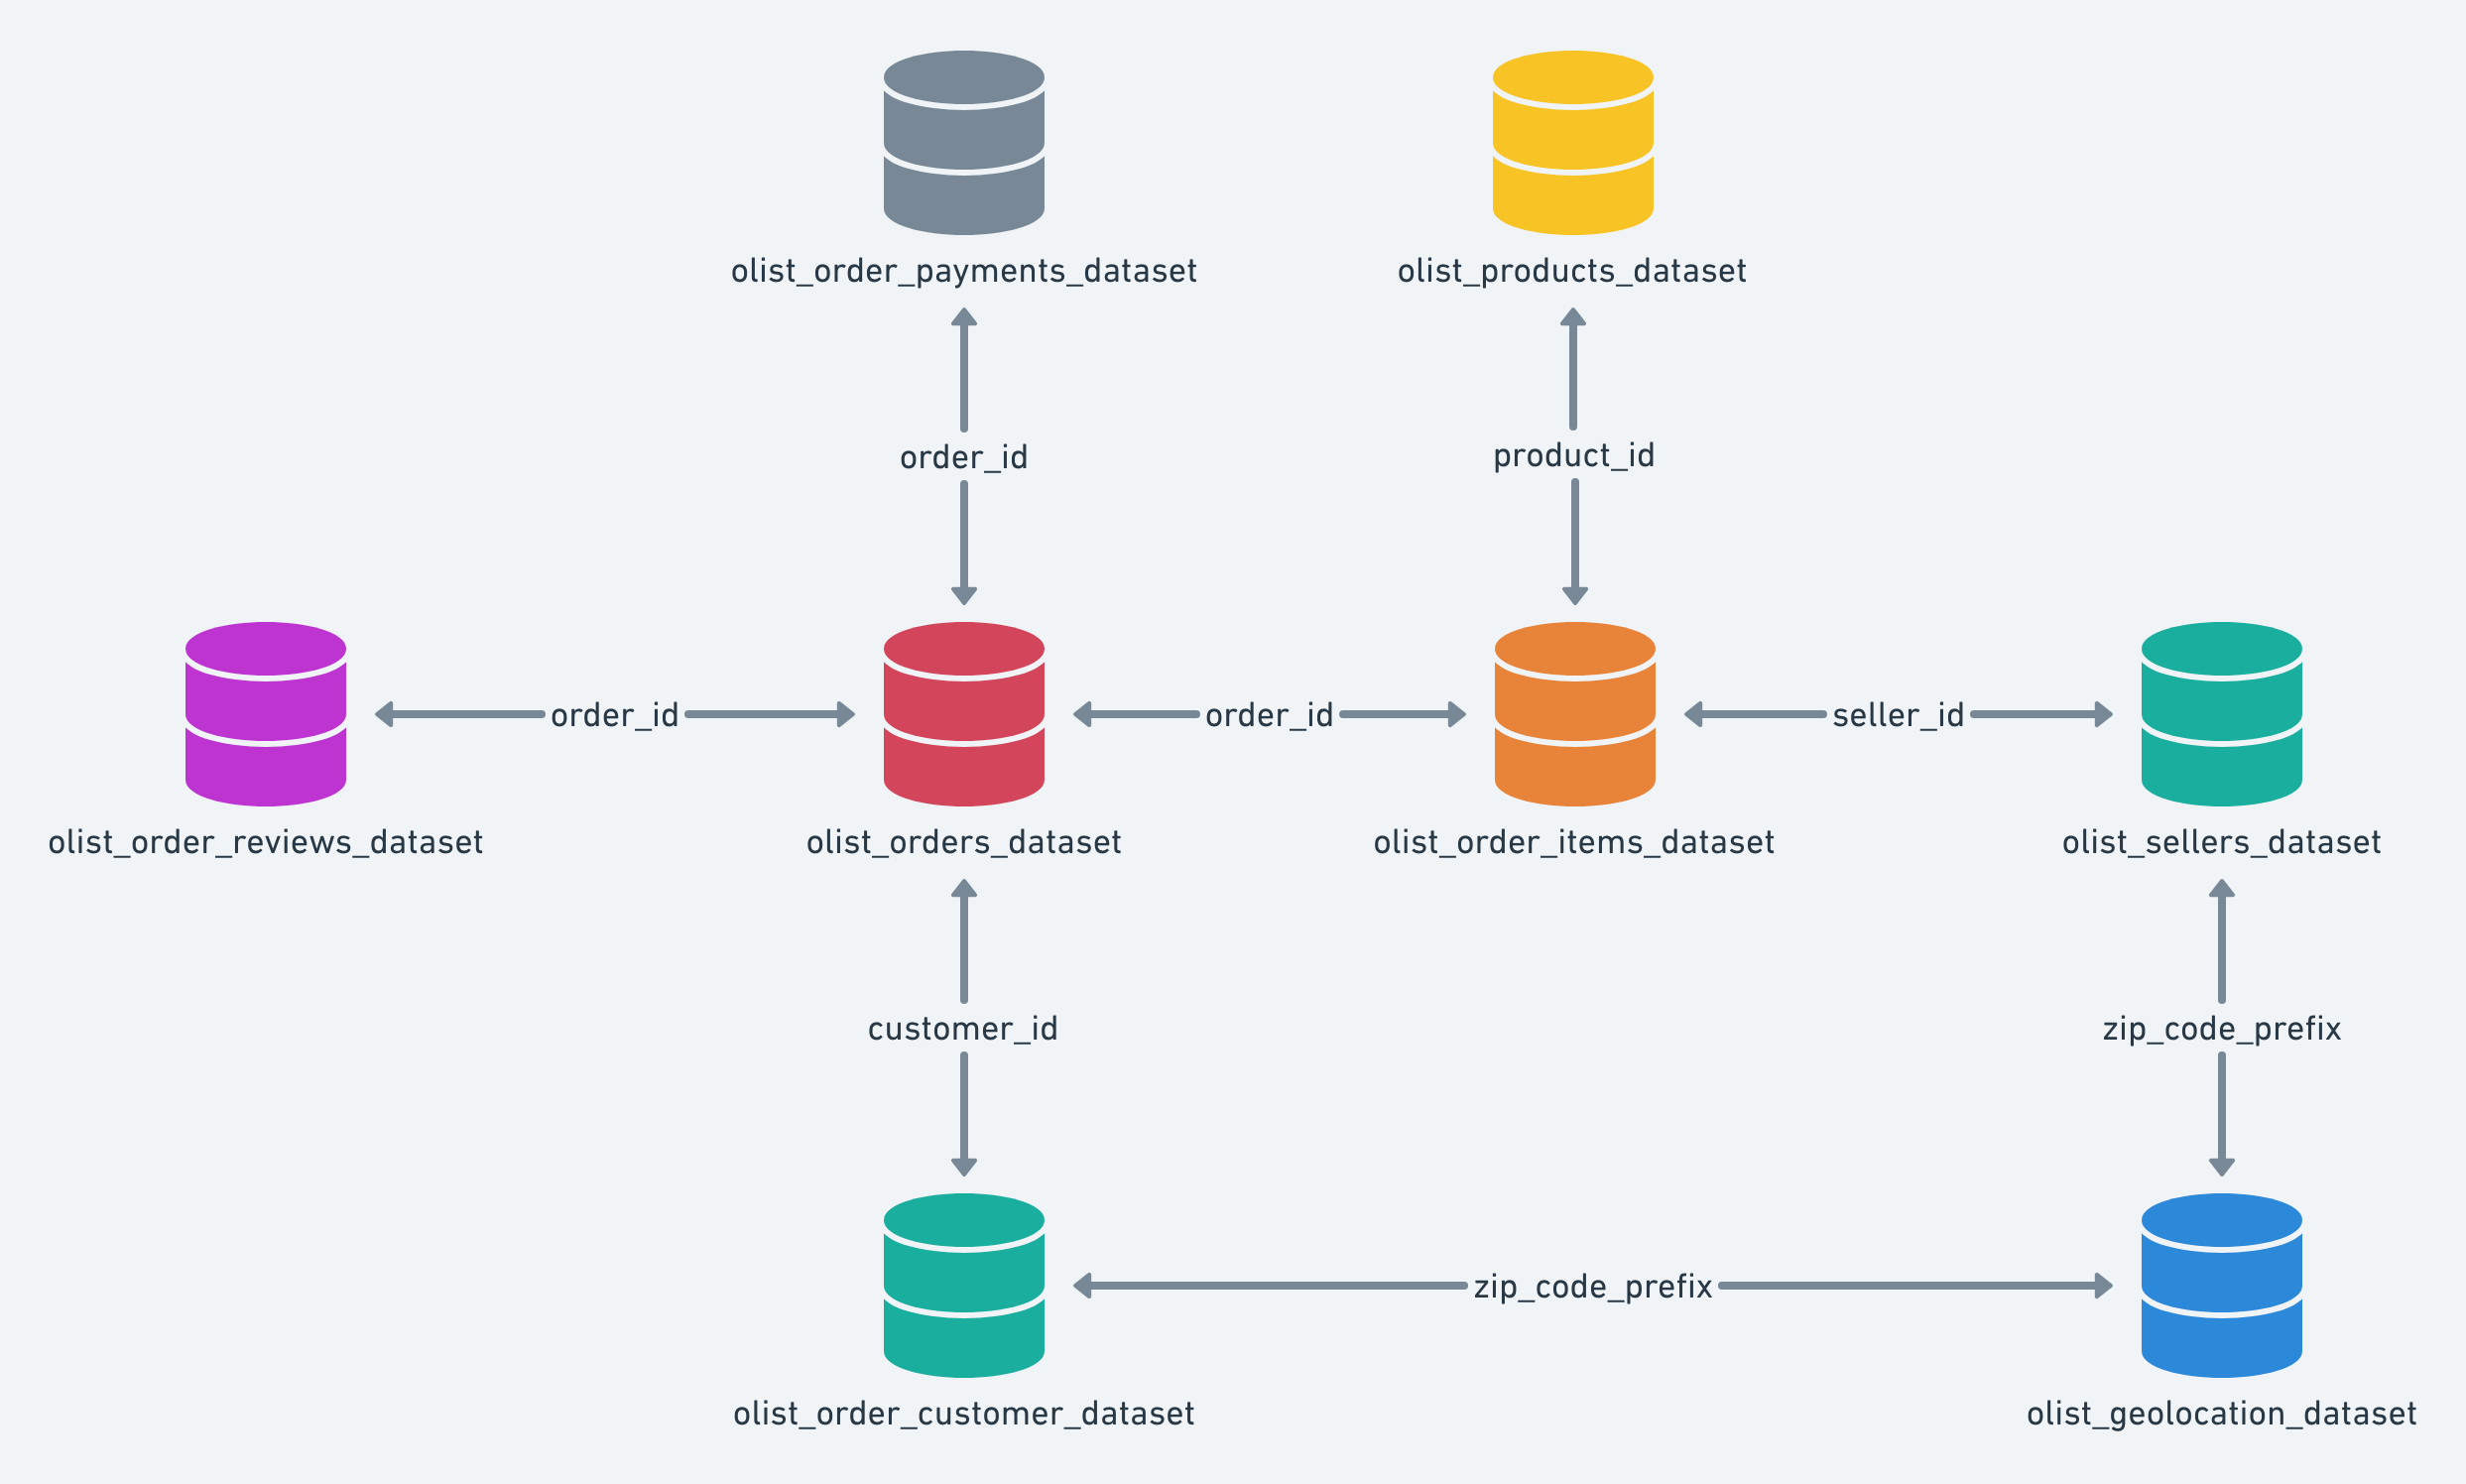

In [2]:
# Display database schema in AWS PostgreSQL
from IPython.display import Image
Image("HRhd2Y0.png")

In [603]:
import pandas as pd
import numpy as np

import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

from scipy.sparse import csr_matrix

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Connecting to AWS Postgres

In [18]:
params = {
    'host': '18.225.37.13',
    'user': 'ubuntu',
    'port': 5432
}

# This is a different way of creating tables
# It is convinient if there are many columns
from sqlalchemy import create_engine
connection_string = f'postgres://ubuntu:{params["host"]}@{params["host"]}:{params["port"]}/olist'
engine = create_engine(connection_string)

In [19]:
connection = pg.connect(**params)

# Loading and Cleaning Data

## Querying Data With SQL

In [20]:
def query_aws(query, engine):
    return pd.read_sql(query,engine)

In [22]:
query = """
        SELECT 
            customers.customer_unique_id, 
            customers.customer_zip_code_prefix, 
            customers.customer_city,
            customers.customer_state,
            order_item.order_id,
            order_item.product_id,
            order_item.seller_id,
            order_item.price,
            orders.order_purchase_timestamp,
            orders.order_delivered_customer_date,
            orders.order_estimated_delivery_date,
            payments.payment_type,
            payments.payment_installments,
            payments.payment_value,
            reviews.review_score,
            products.product_weight_g,
            product_category.product_category_name_english,
            sellers.seller_zip_code_prefix,
            sellers.seller_state,
            sellers.seller_state
        FROM customers
            JOIN orders
                on orders.customer_id=customers.customer_id
            JOIN reviews
                on reviews.order_id=orders.order_id
            JOIN order_item
                on order_item.order_id=orders.order_id
            JOIN payments
                on payments.order_id=orders.order_id
            JOIN products
                on products.product_id=order_item.product_id
            JOIN product_category
                on product_category.product_category_name=products.product_category_name
            JOIN sellers
                on sellers.seller_id=order_item.seller_id
            
        """

olist_data = query_aws(query, engine)

In [23]:
# Save dataset to csv file
olist_data.to_csv('data/01_olist_aws_pulled.csv')

In [363]:
olist_data = pd.read_csv('data/01_olist_aws_pulled.csv')

## Viewing and Cleaning

In [364]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 21 columns):
Unnamed: 0                       116581 non-null int64
customer_unique_id               116581 non-null object
customer_zip_code_prefix         116581 non-null int64
customer_city                    116581 non-null object
customer_state                   116581 non-null object
order_id                         116581 non-null object
product_id                       116581 non-null object
seller_id                        116581 non-null object
price                            116581 non-null float64
order_purchase_timestamp         116581 non-null object
order_delivered_customer_date    114066 non-null object
order_estimated_delivery_date    116581 non-null object
payment_type                     116581 non-null object
payment_installments             116581 non-null int64
payment_value                    116581 non-null float64
review_score                     116581 non-null i

In [365]:
olist_data = olist_data.drop(columns=['Unnamed: 0', 'seller_state.1'])

In [366]:
# some purchases are payed with by vouchers which causes them to split into many lines of
# smaller payments. To normalize with the rest of the data, combining these values into 
# one total payment value

def create_total_payment_value(data):
    data['total_payment'] = data['payment_value'].groupby(data['order_id']).transform('sum')
    data= data.drop('payment_value', axis=1)
    return data

In [367]:
olist_data = create_total_payment_value(olist_data)

In [368]:
def duplicates(data):
    """Prints the number of duplicates in the input dataset, removes duplicate values keeping only the 
    first entry, and returns a dataset with no duplicate values."""
    
    # Confirm number of duplicate rows
    print(f"There are {data.duplicated().sum()} duplicate rows.")

    # Remove any duplicates, keeping only the first entry
    data = data.drop_duplicates(keep='first')

    # Confirm duplicates were removed correctly
    print(f"After dropping, there are {data.duplicated().sum()} duplicate rows.")
    print(f"Returned dataset has {data.shape[0]} rows")
    
    return data

In [369]:
olist_data = duplicates(olist_data)

There are 12969 duplicate rows.
After dropping, there are 0 duplicate rows.
Returned dataset has 103612 rows


In [408]:
# Convert order timestamp to datetime 
def convert_to_datetime(data):
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp, 
                                                     format="%Y/%m/%d %H:%M:%S")
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date, 
                                                        format="%Y/%m/%d %H:%M:%S")
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date, 
                                                        format="%Y/%m/%d %H:%M:%S")
    return data

olist_data = convert_to_datetime(olist_data)

In [371]:
# Adding 99% to 7 digit summary to understand how drastic the max_price outlier is
olist_data.describe([.75,.99])

,customer_zip_code_prefix,price,payment_installments,review_score,product_weight_g,seller_zip_code_prefix,total_payment
count,103612.000000,103612.000000,103612.000000,103612.000000,103611.000000,103612.000000,103612.000000
mean,35125.539918,124.490286,2.937150,4.061489,2096.389785,24627.129126,231.038923
std,29771.870475,188.972184,2.743117,1.364238,3750.600705,27678.848789,692.432702
min,1003.000000,0.850000,0.000000,1.000000,0.000000,1001.000000,9.590000
50%,24435.000000,78.000000,2.000000,5.000000,700.000000,13720.000000,114.760000
75%,58741.250000,139.000000,4.000000,5.000000,1800.000000,29156.000000,212.092500
99%,97541.000000,899.000000,10.000000,5.000000,18250.000000,93542.000000,1957.020000
max,99980.000000,6735.000000,24.000000,5.000000,40425.000000,99730.000000,109312.640000


In [372]:
# For now, not removing outliers but note that price and payment values both contain significan outliers

In [410]:
olist_data.to_csv('data/cleaned_olist_data.csv', index=False)

In [374]:
olist_data=pd.read_csv('data/cleaned_olist_data.csv')

In [409]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103612 entries, 0 to 103611
Data columns (total 19 columns):
customer_unique_id               103612 non-null object
customer_zip_code_prefix         103612 non-null int64
customer_city                    103612 non-null object
customer_state                   103612 non-null object
order_id                         103612 non-null object
product_id                       103612 non-null object
seller_id                        103612 non-null object
price                            103612 non-null float64
order_purchase_timestamp         103612 non-null datetime64[ns]
order_delivered_customer_date    101386 non-null datetime64[ns]
order_estimated_delivery_date    103612 non-null datetime64[ns]
payment_type                     103612 non-null object
payment_installments             103612 non-null int64
review_score                     103612 non-null int64
product_weight_g                 103611 non-null float64
product_category_name_engl

# EDA

In [12]:
olist_blue  = '#0C29D1'
olist_green = '#0CC78B'

In [31]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116581 entries, 0 to 116580
Data columns (total 21 columns):
Unnamed: 0                       116581 non-null int64
customer_unique_id               116581 non-null object
customer_zip_code_prefix         116581 non-null int64
customer_city                    116581 non-null object
customer_state                   116581 non-null object
order_id                         116581 non-null object
product_id                       116581 non-null object
seller_id                        116581 non-null object
price                            116581 non-null float64
order_purchase_timestamp         116581 non-null datetime64[ns]
order_delivered_customer_date    114066 non-null datetime64[ns]
order_estimated_delivery_date    116581 non-null datetime64[ns]
payment_type                     116581 non-null object
payment_installments             116581 non-null int64
payment_value                    116581 non-null float64
review_score              

## Consumers

In [11]:
olist_data.shape

(116581, 18)

In [9]:
# number of unique customers
olist_data.customer_unique_id.nunique()

94087

In [36]:
# Number of repeat customers
olist_data.shape[0] - olist_data.customer_unique_id.nunique()

22494

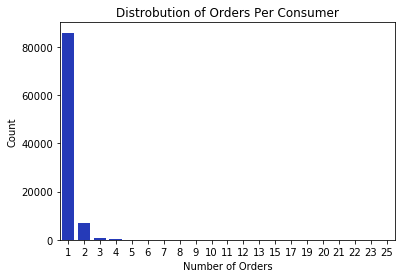

In [412]:
# Distrobution of orders per customer

def order_per_consumer(data):
    return data.groupby('customer_unique_id')['order_id'].agg(['count'])
    
orders_per_consumer = order_per_consumer(olist_data)

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.countplot(orders_per_consumer['count'], color=olist_blue)
ax.set(xlabel='Number of Orders', ylabel='Count', title='Distrobution of Orders Per Consumer');

In [169]:
# Number of repeat consumers vs single time consumers

def repeat_customers(data):
    repeat_customers = data.customer_unique_id.value_counts()
    return repeat_customers[repeat_customers > 1].count()

repeat_customers(olist_data)

8272

In [255]:
# Customer locations throughout Brazil

def customer_locations(data):
    return pd.DataFrame(data.customer_city.value_counts().sort_values(ascending=False))

customer_locations = customer_locations(olist_data).reset_index().rename(columns={'index': 'city', 'customer_city':'num_customers'})

print(f"There are {customer_locations.city.nunique()} unique customer cities.\n")

top_ten_cities = customer_locations.city[:10]
customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)

print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

There are 4095 unique customer cities.

The majority of customers, 35.22 percent, live in the top ten cities.



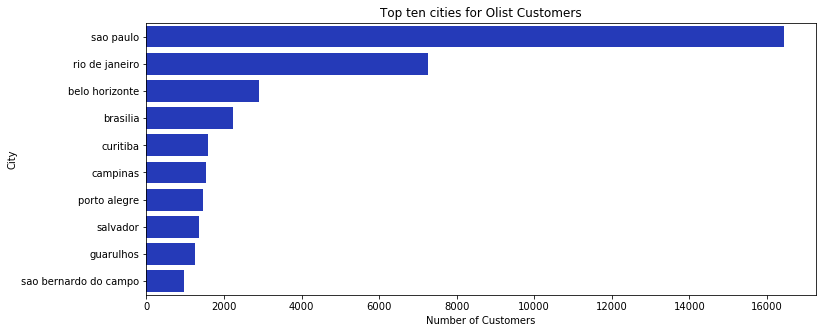

In [413]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
sns.barplot(x=customer_locations.num_customers[:10], y=top_ten_cities, ax=ax, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='City', title='Top ten cities for Olist Customers');

## Orders

In [195]:
# Number of orders per day

def order_per_day(data):
    return data.groupby(data.order_purchase_timestamp.dt.date)['order_id'].agg(['count'])

order_per_day = order_per_day(olist_data)

print(f"Avg. number of orders per day: {np.mean(order_per_day)[0]}")

Avg. number of orders per day: 170.8780487804878


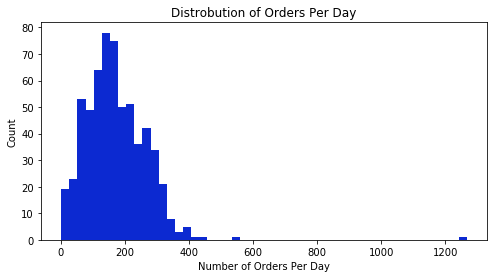

In [414]:
# Distrobution of orders per day
plt.figure(figsize=(8,4))
plt.hist(order_per_day['count'], bins=50, color=olist_blue)
plt.xlabel('Number of Orders Per Day')
plt.ylabel('Count')
plt.title('Distrobution of Orders Per Day');

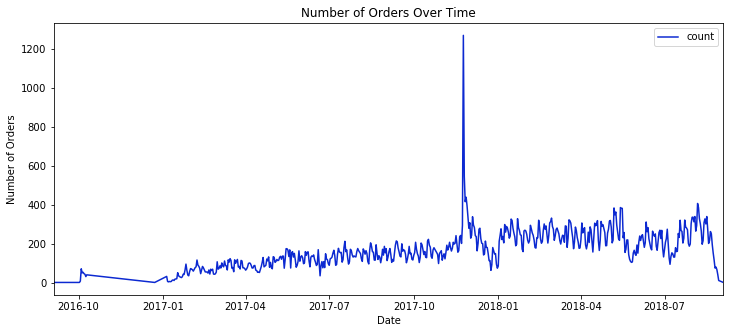

In [415]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
order_per_day.plot(ax=ax, use_index=True, color=olist_blue)
ax.set(xlabel='Date', ylabel='Number of Orders', title='Number of Orders Over Time');

There is a spike in orders around Christmas of 2017 but otherwise we see a pattern of general inflation of orders 

Avg. purchase price: 159.2856598632461


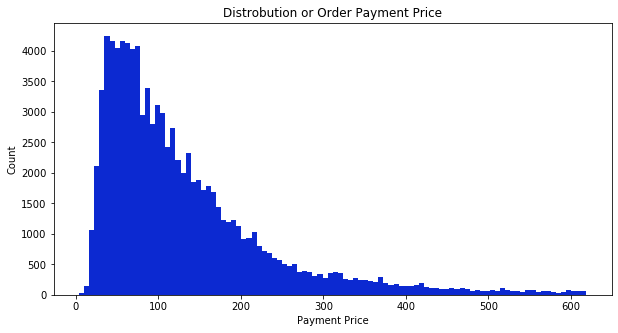

In [416]:
# Each line item represents a single item in an order. Group by order_id to find total purchase price for all orders
def purchase_payment_val(data):
    return data.groupby('order_id').payment_value.max()

purchase_payments = purchase_payment_val(olist_data)

print(f"Avg. purchase price: {purchase_payments.mean()}")


# view purchase price removing outliers in the top 3%
q_97 = purchase_payments.quantile(.97)
payments_97 = purchase_payments[purchase_payments < q_97]

# plot distrobution
plt.figure(figsize=(10,5))
plt.hist(payments_97, bins=100, color=olist_blue)
plt.xlabel('Payment Price')
plt.ylabel('Count')
plt.title('Distrobution or Order Payment Price');

In [289]:
# Number of items per order
def items_per_order(data):
    return data.groupby('order_id').product_id.agg(['count']).sort_values(by='count')

avg_items_per_order = items_per_order(olist_data).mean()

print(f"Avg. number of items per order: {avg_items_per_order[0]}")

Avg. number of items per order: 1.0805614107243844


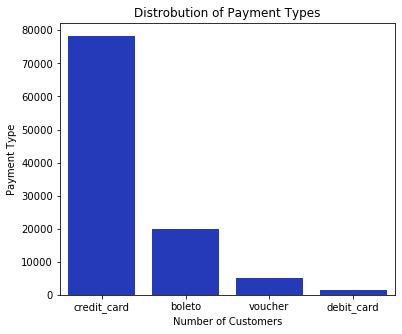

In [417]:
# Payment methods
def payment_types(data):
    return data.payment_type.value_counts()

payment_types = payment_types(olist_data)

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
sns.barplot(x=payment_types.index, y=payment_types.values, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='Payment Type', title='Distrobution of Payment Types');

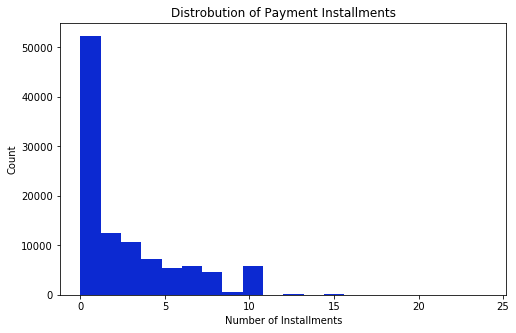

In [418]:
# Installments
plt.figure(figsize=(8,5))
plt.hist(olist_data.payment_installments, color=olist_blue, bins=20)
plt.xlabel('Number of Installments')
plt.ylabel('Count')
plt.title('Distrobution of Payment Installments');

## Sellers

In [ ]:
# Sales per seller

Avg. number of sales per seller: 34.648862512364

The top 10 sellers account for 14.28 percent of the total sales

The top seller has 2061 sales


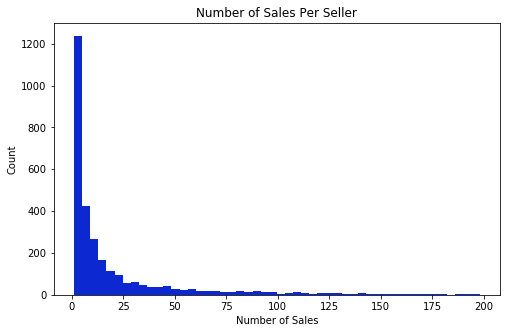

In [419]:
def sales_per_seller(data):
    return data.groupby('seller_id')['order_id'].count()

sales_per_seller = sales_per_seller(olist_data)

print(f"Avg. number of sales per seller: {sales_per_seller.mean()}\n")

top_ten_sellers = sales_per_seller.sort_values(ascending=False)[:10]
sales_in_top_ten_sellers = round(top_ten_sellers.values.sum()/sales_per_seller.values.sum()*100,2)

print(f"The top 10 sellers account for {sales_in_top_ten_sellers} percent of the total sales\n")

print(f"The top seller has {top_ten_sellers[0]} sales")

# view purchase price removing outliers in the top 3%
s_q_97 = sales_per_seller.quantile(.97)
sellers_q_97 = sales_per_seller[sales_per_seller < s_q_97]


plt.figure(figsize=(8,5))
plt.hist(sellers_q_97, bins=50, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller');

## Products

Number of unique products: 32328

Average price per product: 120.75136917679554

Average sales per product: 3.6061927740658253

Top ten selling products:
aca2eb7d00ea1a7b8ebd4e68314663af    536
99a4788cb24856965c36a24e339b6058    528
422879e10f46682990de24d770e7f83d    508
389d119b48cf3043d311335e499d9c6b    406
368c6c730842d78016ad823897a372db    398
53759a2ecddad2bb87a079a1f1519f73    391
d1c427060a0f73f6b889a5c7c61f2ac4    357
53b36df67ebb7c41585e8d54d6772e08    327
154e7e31ebfa092203795c972e5804a6    295
3dd2a17168ec895c781a9191c1e95ad7    278
Name: product_id, dtype: int64

The top ten selling products account for 3.45 percent of the product sold.



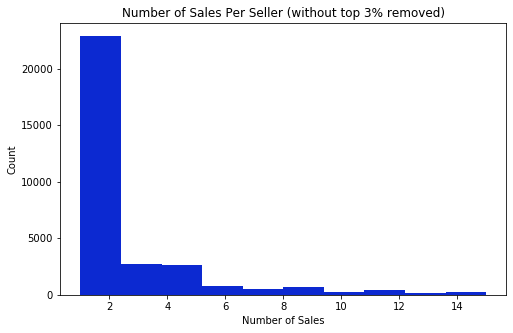

In [58]:
# Average product cost
print(f"Number of unique products: {olist_data.product_id.nunique()}\n")
print(f"Average price per product: {olist_data.price.mean()}\n")

# Most sold products
def num_products_sold(data):
    return data.product_id.value_counts()

number_prod_sold = num_products_sold(olist_data)

print(f"Average sales per product: {number_prod_sold.mean()}\n")

top_ten_products = number_prod_sold[:10]
print(f"Top ten selling products:\n{top_ten_products}\n")
print(f"The top ten selling products account for {round(top_ten_products.values.sum()/number_prod_sold.values.sum()*100,2)} percent of the product sold.\n")


p_q_97 = number_prod_sold.quantile(.97)
products_q_97 = number_prod_sold[number_prod_sold < p_q_97]

plt.figure(figsize=(8,5))
plt.hist(products_q_97, bins=10, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller (without top 3% removed)');

The top reviewed products are
                              product_id  mean  count
29803  ebf9bc6cd600eadd681384e3116fda85   5.0     44
627    0554911df28fda9fd668ce5ba5949695   5.0     38
11942  5ddab10d5e0a23acb99acf56b62b3276   5.0     21
16932  85b99d83c60cab5b4d8f927ad35212a1   5.0     17
23419  b9aad83bfbc546d2e4e7a7fa8e15bc9c   5.0     16
995    07f01b6fcacc1b187a71e5074199db2d   5.0     15
7133   37eb69aca8718e843d897aa7b82f462d   5.0     15
20022  9e5f752e9e19cd6887063f004ee0da55   5.0     15
22907  b5ebab9fa4b5f2771ec47a5d6139f3ff   5.0     15
457    03e1c946c0ddfc58724ff262aef08dff   5.0     14


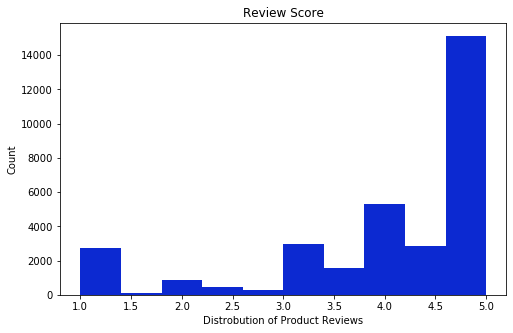

In [51]:
# Top reviewed products as determined by rating and number of reviews
def product_reviews(data):
    return data.groupby('product_id')['review_score'].agg(['mean', 'count']).reset_index()

reviewed_products = product_reviews(olist_data)
top_ten_reviewed_products = reviewed_products.sort_values(by=['mean','count'],ascending=False)[:10]

print(f"The top reviewed products are\n {top_ten_reviewed_products}")


plt.figure(figsize=(8,5))
plt.hist(reviewed_products['mean'], bins=10, color=olist_blue)
plt.xlabel('Distrobution of Product Reviews')
plt.ylabel('Count')
plt.title('Review Score');

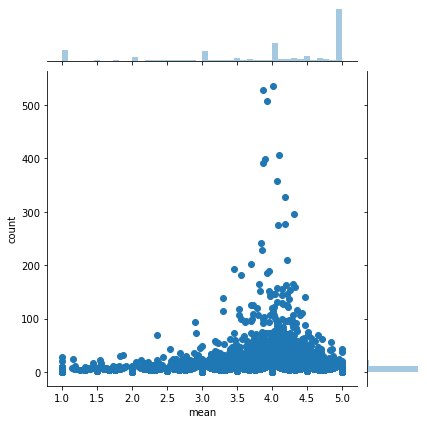

In [53]:
# observe the relationship between rating and number of reviews
sns.jointplot(x=reviewed_products['mean'], y=reviewed_products['count'], data=reviewed_products);

There are 71 categories


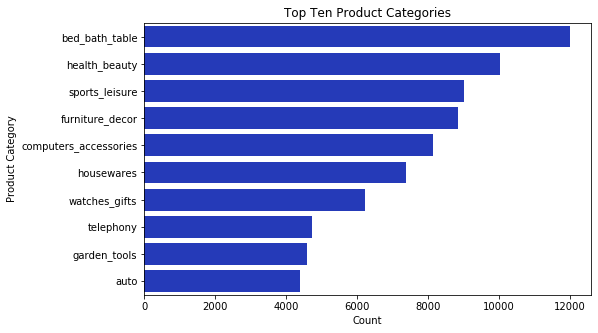

In [18]:
# Product cateogires

print(f"There are {olist_data.product_category_name_english.nunique()} categories")

top_ten_categories = olist_data.product_category_name_english.value_counts().sort_values(ascending=False)[:10]

plt.figure(figsize=(8,5))
ax = sns.barplot(top_ten_categories.values, top_ten_categories.index, color=olist_blue)
ax.set(xlabel='Count', ylabel='Product Category', title='Top Ten Product Categories');

# Separating Repeat and First Time Users

When entering the site, the customers are flagged as a repeat customer or new customer and handled as follows.  

**Repeat Customers:** Collaborative filtering is used to recommend products. Results are measured by how many predictions are right using the recommender vs. how many are right when just recommending the most popular item.  

**For New Users:** Recommendation based on 
* Customer Segmentation, then pick the top product in that customer base
* People in your area, then pick the top products in that customer base   

Results are measured by comparing predictions to the overall most popular item

In [411]:
def repeat_and_first_time(data):
    """Takes in a dataset and returns back the dataset with only repeated customers"""
    repeaters = data.groupby('customer_unique_id').filter(lambda x: len(x) > 1)
    first_timers = data.groupby('customer_unique_id').filter(lambda x: len(x) == 1)
    return repeaters, first_timers

In [412]:
repeater_data, first_timer_data = repeat_and_first_time(olist_data)

In [413]:
# Save datasets for easier accessing
repeater_data.to_csv('data/repeater_data.csv')
first_timer_data.to_csv('data/first_timer_data.csv')

In [414]:
# View the size of the new datasets
print("Shape of repeater dataset:", repeater_data.shape)

print("Shape of first timer dataset:", first_timer_data.shape)

Shape of repeater dataset: (17313, 19)
Shape of first timer dataset: (86299, 19)


# Repeat Customers

The full data set is filtered down to only repeat customers. Train data is all purchases except for the most recent. Test set includes the last order from each customer. The goal is to predict the most recent purchase (conceptually it is the next order after the train set).

## Preparing Dataframes

### Method 1: Purchase Count

In [642]:
def create_puchase_count_df(data):
    purchase_count = pd.melt(data.set_index('customer_unique_id')['product_id'].apply(pd.Series).reset_index(), 
                 id_vars=['customer_unique_id'],
                 value_name='product_id')
    purchase_count = purchase_count.dropna().drop(['variable'], axis=1)
    purchase_count = purchase_count.groupby(['customer_unique_id', 'product_id']).agg({'product_id': 'count'})
    purchase_count = purchase_count.rename(columns={'product_id': 'estimator'}).reset_index()
    purchase_count = purchase_count.rename(columns={'product_id': 'productId'})
    
    return purchase_count

In [643]:
purchase_count_df = create_puchase_count_df(repeater_data)

In [644]:
purchase_count_df.head()

,customer_unique_id,productId,estimator
0,00053a61a98854899e70ed204dd4bafe,58727e154e8e85d84052cd22b0136c84,1
1,00053a61a98854899e70ed204dd4bafe,62984ea1bba7fcea1f5b57084d3bf885,1
2,000bfa1d2f1a41876493be685390d6d3,bb15f9ba2ec6e36ab6c9e88d17430d64,2
3,000de6019bb59f34c099a907c151d855,9e572ff4654f7064419d97a891a8b0fc,1
4,000de6019bb59f34c099a907c151d855,af0a917aec9cea3b353ece61a8825326,1


### Method 2: Dummy Variables

In [657]:
def create_data_dummy(data):
    data_dummy = data.copy()
    data_dummy['estimator2'] = 1
    data_dummy = data_dummy.drop('estimator', axis=1)
    data_dummy = data_dummy.rename({'estimator2':'estimator'}, axis=1)
    return data_dummy

In [658]:
dummy_df = create_data_dummy(purchase_count_df)

In [659]:
dummy_df.head()

,customer_unique_id,productId,estimator
0,00053a61a98854899e70ed204dd4bafe,58727e154e8e85d84052cd22b0136c84,1
1,00053a61a98854899e70ed204dd4bafe,62984ea1bba7fcea1f5b57084d3bf885,1
2,000bfa1d2f1a41876493be685390d6d3,bb15f9ba2ec6e36ab6c9e88d17430d64,1
3,000de6019bb59f34c099a907c151d855,9e572ff4654f7064419d97a891a8b0fc,1
4,000de6019bb59f34c099a907c151d855,af0a917aec9cea3b353ece61a8825326,1


### Method 3: Normalize Purchase Frequency

In [663]:
def normalize_purchase_count(data):
    count_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    count_matrix_norm = (count_matrix-count_matrix.min())/(count_matrix.max()-count_matrix.min())
    count_matrix_norm = count_matrix_norm.reset_index()
    count_matrix_norm.index.names = ['scaled_purchase_freq']
    
    normalized_count_matrix = pd.melt(count_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_count_matrix

In [664]:
normalized_purchase_count_df = normalize_purchase_count(purchase_count_df)

In [665]:
normalized_purchase_count_df.head()

,customer_unique_id,productId,estimator
17446,3f36fa15a16c4850992aa0f33561906e,00210e41887c2a8ef9f791ebc780cc36,0.0
20383,9e37889f07854b8ae7d49bcbb49ffaf2,00210e41887c2a8ef9f791ebc780cc36,1.0
162091,d02cbb85434c84acabb8e81bbf064d3e,00baba5b58e274d0332a0c8a0a66f877,1.0
162250,d567f29ec5fa447c99e949f337f3a35c,00baba5b58e274d0332a0c8a0a66f877,0.0
211988,397b44d5bb99eabf54ea9c2b41ebb905,00faa46f36261af8bbf3a4d37fa4841b,1.0


### Method 4: User Ratings Matrix

In [666]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
    
#     user_prod_reviewscore_data.avg_rating = user_prod_reviewscore_data.avg_rating.apply(lambda x: 1)
    
    return user_prod_reviewscore_data

In [667]:
user_ratings_df = create_user_ratings_df(repeater_data)

In [668]:
user_ratings_df.head()

,customer_unique_id,productId,estimator
0,00053a61a98854899e70ed204dd4bafe,58727e154e8e85d84052cd22b0136c84,1.0
1,00053a61a98854899e70ed204dd4bafe,62984ea1bba7fcea1f5b57084d3bf885,1.0
2,000bfa1d2f1a41876493be685390d6d3,bb15f9ba2ec6e36ab6c9e88d17430d64,4.5
3,000de6019bb59f34c099a907c151d855,9e572ff4654f7064419d97a891a8b0fc,2.0
4,000de6019bb59f34c099a907c151d855,af0a917aec9cea3b353ece61a8825326,2.0


### Method 5: Normalized User Ratings Matrix

In [669]:
def normalize_purchase_count(data):
    ratings_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    ratings_matrix_norm = (ratings_matrix-ratings_matrix.min())/(ratings_matrix.max()-ratings_matrix.min())
    ratings_matrix_norm = ratings_matrix_norm.reset_index()
    ratings_matrix_norm.index.names = ['estimator']
    
    normalized_ratings_matrix = pd.melt(ratings_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_ratings_matrix

In [670]:
normalized_user_ratings_df = normalize_purchase_count(user_ratings_df)

In [673]:
normalized_user_ratings_df.head()

,customer_unique_id,productId,estimator
17446,3f36fa15a16c4850992aa0f33561906e,00210e41887c2a8ef9f791ebc780cc36,1.0
20383,9e37889f07854b8ae7d49bcbb49ffaf2,00210e41887c2a8ef9f791ebc780cc36,0.0
69358,e76c6b66892fdab38f6bafcd081e034e,003dbcabcf8e3231de657c7d9f9a5eba,1.0
69908,f99f4e4db672e22718b5ad0e910ede8a,003dbcabcf8e3231de657c7d9f9a5eba,0.0
83164,ae864af1d62fc952073ddcd1ab59a233,005030ef108f58b46b78116f754d8d38,1.0


## Modeling

## Determinging Model Framework

In [829]:
def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df

# Split data into 5 kfolds
kf = KFold(n_splits=5, shuffle=True, random_state=19)

# Helper function to test different types of collaborative filtering
def model_framework(train_data):
    
    test_df = surprise_df(train_data)
    
    normp_rmse, svd_rmse, knn_rmse, co_rmse, slope_rmse = [], [], [], [], []

    for trainset, testset in kf.split(test_df): #iterate through the folds.
        
        #baseline
        normp = NormalPredictor()
        normp.fit(trainset)
        normp_pred = normp.test(testset)
        normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))
        
        #svd
        svd = SVD(n_factors=30, n_epochs=50,biased=True, lr_all=0.005, reg_all=0.4, verbose=False)
        svd.fit(trainset)
        svd_pred = svd.test(testset)
        svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
        
        #knn
        knn = KNNBasic(k=40,sim_options={'name': 'cosine', 'user_based': False}, verbose=False) 
        knn.fit(trainset)
        knn_pred = knn.test(testset)
        knn_rmse.append(accuracy.rmse(knn_pred,verbose=False))
        
        #co_clustering
        co = CoClustering(n_cltr_u=3,n_cltr_i=3,n_epochs=20)         
        co.fit(trainset)
        co_pred = co.test(testset)
        co_rmse.append(accuracy.rmse(co_pred,verbose=False))
        
        #slope_one
        slope = SlopeOne() 
        slope.fit(trainset)
        slope_pred = slope.test(testset)
        slope_rmse.append(accuracy.rmse(slope_pred,verbose=False))
    
    mean_rmses = [np.mean(normp_rmse),
                  np.mean(svd_rmse),
                  np.mean(knn_rmse),
                  np.mean(co_rmse),
                  np.mean(slope_rmse)]
    
    model_names = ['baseline', 'svd','knn','coclustering','slopeone']
    compare_df = pd.DataFrame(mean_rmses, index=model_names)
    
    return compare_df

In [834]:
def model_comparison(all_methods):
    comp_matrix = model_framework(all_methods[0]).transpose()
    print('Initial dataframe created.')
    
    for method in all_methods[1:]:
        temp_df = model_framework(method).transpose()
        comp_matrix = pd.concat((comp_matrix,temp_df), axis=0)
        print("Layer added to dataframe.")
        
    comp_matrix = comp_matrix.set_index([['purchase_count', 
                                       'dummy',
                                       'norm_purchase_count', 
                                       'user_ratings', 
                                       'norm_user_ratings']])
    
    return comp_matrix
    

In [835]:
all_methods = [purchase_count_df, dummy_df, normalized_purchase_count_df, user_ratings_df, normalized_user_ratings_df]

In [836]:
comparison_matrix = model_comparison(all_methods)

Initial dataframe created.
Layer added to dataframe.
Layer added to dataframe.
Layer added to dataframe.
Layer added to dataframe.


In [845]:
# create a column to indicate percentage better performance than baseline so that 
# centered and non-centered datasets can be compared
comparison_matrix['best_score'] = comparison_matrix.min(axis=1)
comparison_matrix['method_comparison'] = 100*(1-(comparison_matrix.best_score/comparison_matrix.baseline)) 
comparison_matrix

,baseline,svd,knn,coclustering,slopeone,best_score,method_comparison
purchase_count,0.536567,0.410806,0.424937,0.432835,0.415376,0.410806,23.438101
dummy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
norm_purchase_count,0.579549,0.477842,0.462029,0.459033,0.444857,0.444857,23.240896
user_ratings,1.971325,1.362263,1.478314,1.434971,1.339884,1.339884,32.031295
norm_user_ratings,0.563375,0.460869,0.427093,0.456429,0.405887,0.405887,27.954353


Best performer was the user ratings matrix. Although slopeone performed best, svd will be explored using grid search to tune hyperparameters.

## Tuning Winning Model (SVD)

For the final model, will continue to leverage the user rating matrix as it requires minimal computational expense and maximum variance.

### Gridsearch

In [850]:
def gridsearch(data, model, param_grid):
    param_grid = param_grid
    gs = GridSearchCV(model, param_grid, measures=['rmse'], cv=5)
    gs.fit(data)
    
    new_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print("Best score:", best_score)
    print("Best params:", new_params)
    
    return new_params, best_score

In [853]:
# standard svd gridsearch
data = surprise_df(user_ratings_df)

svd_param_grid = {'n_factors': [25, 50,100],'n_epochs': [20,30,50], 'lr_all': [0.002,0.005,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svd_params, svd_score = gridsearch(data, SVD, svd_param_grid)

Best score: 1.276697600716385
Best params: {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [854]:
# svdpp gridsearch

svdpp_param_grid = {'n_factors': [10, 20, 50],'n_epochs': [20,30,50], 'lr_all': [0.002,0.007,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svdpp_params, svdpp_score = gridsearch(data, SVDpp, svdpp_param_grid)

Best score: 1.2741892218744408
Best params: {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


### Comparing all SVD models

In [882]:
def svd_model(data, model_list, model_names):
    all_scores = []
    
    for model in model_list:
        model_rmse = []
        model_mae = []
        
        for trainset, testset in kf.split(data): #iterate through the folds.

            mod = model
            mod.fit(trainset)
            pred = mod.test(testset)
            model_rmse.append(accuracy.rmse(pred,verbose=False))
            model_mae.append(accuracy.mae(pred,verbose=False))
            
        all_scores.append([np.mean(model_rmse), np.mean(model_mae)])
    
    results = pd.DataFrame(all_scores, index=model_names, columns=['rmse','mae'])
    
    return results  

In [883]:
def svd_comparisons():
    # For comparison, baseline model
    random = NormalPredictor()

    # Standard SVD models
    tuned_svd = SVD(n_factors=svd_params['n_factors'], 
                    n_epochs=svd_params['n_epochs'],
                    lr_all=svd_params['lr_all'], 
                    reg_all=svd_params['reg_all'])

    standard_svd = SVD()

    # SVDpp moddels
    tuned_svdpp = SVDpp(n_factors=svdpp_params['n_factors'], 
                        n_epochs=svdpp_params['n_epochs'],
                        lr_all=svdpp_params['lr_all'], 
                        reg_all=svdpp_params['reg_all'])

    standard_svdpp = SVDpp()


    model_list = [random, tuned_svd, standard_svd, tuned_svdpp, standard_svdpp]
    model_names = ['random','tuned_svd','standard_svd','tuned_svdpp','standard_svdpp']

    return svd_model(data, model_list, model_names)

In [884]:
svd_comparison_df = svd_comparisons()
svd_comparison_df

,rmse,mae
random,1.977622,1.559012
tuned_svd,1.284523,1.073183
standard_svd,1.447653,1.244912
tuned_svdpp,1.280175,1.067921
standard_svdpp,1.413678,1.212317


In [887]:
svdpp_performance = 100*(1-(svd_comparison_df.loc['tuned_svdpp', 'rmse'] / svd_comparison_df.loc['random', 'rmse']))
print(f"Tuned SVDpp performed {svdpp_performance} better than baseline.")

Tuned SVDpp performed 35.266922083017924 better than baseline.


## Ensembling Collaborative Filtering Product-Level

In [ ]:
# Need to update this
class HybridFacto(surprise.AlgoBase):
    def __init__(self,epochs, learning_rate,num_models):
        self.alpha = np.array([1/len(num_models)]*len(num_models))
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def fit(self,holdout):
        holdout=holdout.build_full_trainset().build_testset()
        for epoch in range(self.epochs):
            
            predictions = np.array([collabKNN.test(holdout),funkSVD.test(holdout),coClus.test(holdout),slopeOne.test(holdout)])
            maeGradient = [surprise.accuracy.mae(prediction) for prediction in predictions]
            newalpha = self.alpha - learning_rate * maeGradient  
            #convergence check:
            if newalpha - self.alpha < 0.001:
                break
            self.alpha = newalpha
            
    def estimate(self,u,i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
        algoResults = np.array([collabKNN.predict(u,i),funkSVD.predict(u,i),coClus.predict(u,i),slopeOne.predict(u,i)])
        return np.sum(np.dot(self.alpha,algoResults))

## Customer segmentation

# First Time Users

## Popular In Your Area

## Hot Items

In [ ]:
# Likely to sell > average

### popular in your area

In [505]:
# def train_test_by_date(data):
#     #train data
#     test_data = data.groupby('customer_unique_id').apply(lambda x: x.nlargest(1, 'order_purchase_timestamp', keep='first')).reset_index(drop=True)
    
#     #test data
#     mask = test_data
# #     mask = data['order_id'].isin(list(test_data.order_id))
#     train_data = data[~mask]
    
#     if data.order_id.nunique() == (train_data.order_id.nunique() + test_data.order_id.nunique()):
#         print("Number of orders in test and train data = number of orders in origonal dataset.")
#         print(f"There are {train_data.order_id.nunique()} orders in the train set and {test_data.order_id.nunique()} orders in the test_set")
#     else:
#         print("Error. Number of orders is not consistent in train/test and origonal dataset.")
        
#     return train_data, test_data
    

In [483]:
train_user_prod_rating = isolating_user_ratings_features(train_data)
holdout_user_prod_rating = isolating_user_ratings_features(test_data)